In [2]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [3]:
from diffusion import ExactScoreNetwork, ContinuousSBM, ContinuousVPSDE, linear_schedule, power_law_schedule, EulerMaruyama
from hmc import HMC
from hmc_utils import collision_manager

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem setting

## GMM dataset

In [5]:
## Dummy GMM dataset.
# Centers are going to be located on each lattice point of a 5x5 grid.
ndim = 2
sqrt_n_centers = 4
centers = torch.tensor([[i, j] for i in range(sqrt_n_centers) for j in range(sqrt_n_centers)], dtype=torch.float32)
centers -=torch.tensor([1,1])*(sqrt_n_centers-1)/2

n_centers = centers.shape[0]

weights = torch.ones(n_centers)/n_centers

stds = torch.ones(n_centers, 1)* 0.1

def sample(n_samples):
    center_idxs = torch.multinomial(weights, n_samples, replacement=True)
    samples = centers[center_idxs] + torch.randn(n_samples, ndim) * stds[center_idxs]
    return samples

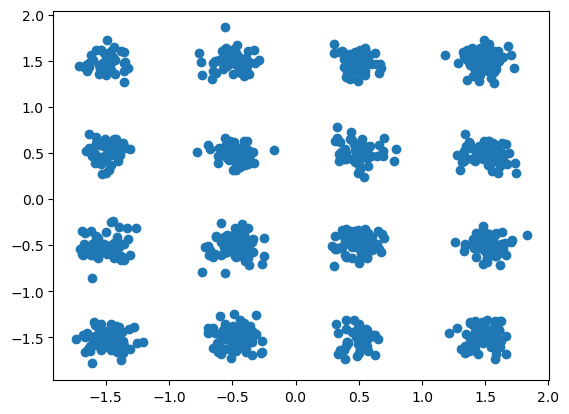

In [6]:
## Sample 1000 points from the GMM.

n_samples = 1000
data = sample(n_samples)

#Plot the data
plt.scatter(data[:,0], data[:,1])

In [7]:
# If you want to train something...
train = False
if train:
    n_dataset = 100000
    data = sample(n_dataset)
    split = int(n_dataset*0.8)
    train_data = data[:split]
    test_data = data[split:]

    train_dataset = torch.utils.data.TensorDataset(train_data)
    test_dataset = torch.utils.data.TensorDataset(test_data)

    batch_size = 1000

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Stochastic Differential Equation

In [8]:
sde = ContinuousVPSDE()

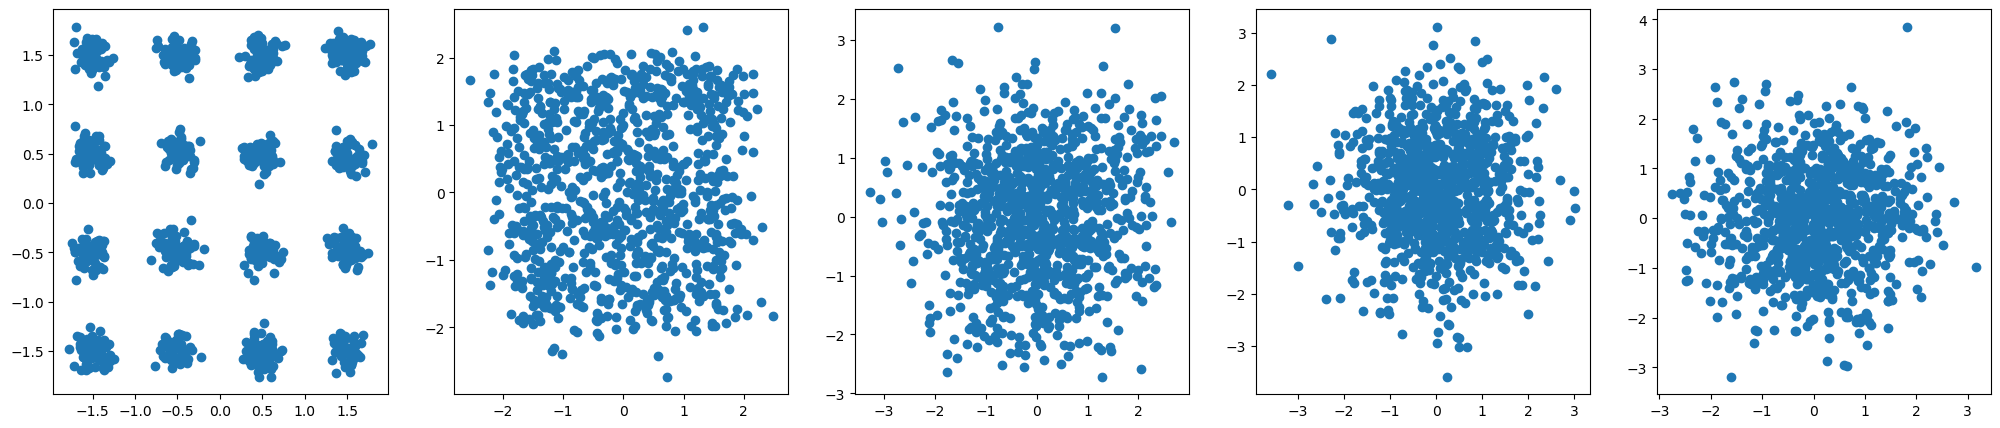

In [9]:
# Test the sde object sampling method for different timesteps (0, 0.1, 0.3, 0.5 and 1)
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
times = [0, 0.1, 0.3, 0.5, 1]
samples = sample(1000)
for i, t in enumerate(times):
    timesteps = torch.ones(1000)*t
    noisy_samples, _, _ = sde.sampling(samples, timesteps)
    ax[i].scatter(noisy_samples[:,0], noisy_samples[:,1])

## Score Based Model

In [10]:
exact_score_net = ExactScoreNetwork(centers, stds, weights).to(device)
exact_dm = ContinuousSBM(sde, exact_score_net).to(device)

### Test it

In [11]:
## Generate 1000 datapoints and plot them
n_samples = 10000
t = torch.ones(n_samples).to(device)*1
tmin = torch.ones(n_samples).to(device)*sde.tmin
schedule = power_law_schedule(t_min = tmin, t_max = t, n_iter = 1000, power = 2)
samples = exact_dm.generate_image(n_samples, schedule = schedule.to(device))

In [12]:
samples = samples.cpu().detach().numpy()

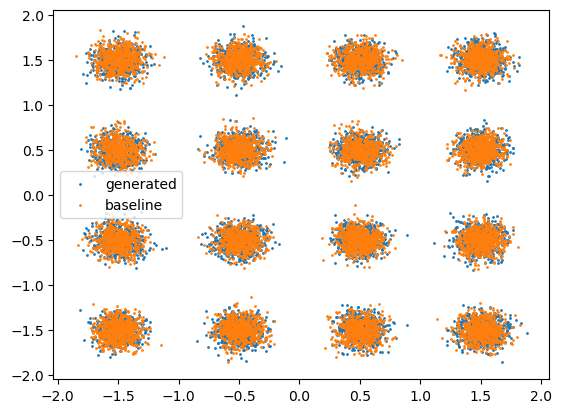

In [13]:
## Plot generated samples
plt.scatter(samples[:,0], samples[:,1], label = 'generated', s=1)
baseline = sample(n_samples).cpu().numpy()
plt.scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1)
plt.legend()

Text(0.5, 1.0, 'Baseline')

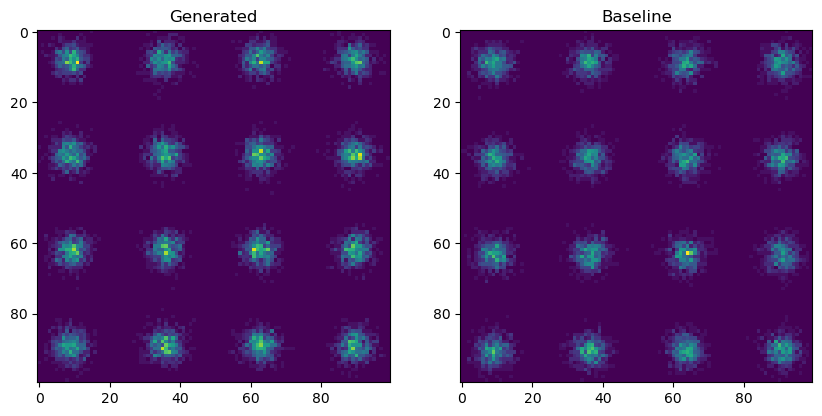

In [14]:
## Plot the empirical distribution of the generated samples and the baseline

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
hist_generated = np.histogram2d(samples[:,0], samples[:,1], bins = 100)
hist_baseline = np.histogram2d(baseline[:,0], baseline[:,1], bins = 100)
ax[0].imshow(hist_generated[0])
ax[0].set_title('Generated')
ax[1].imshow(hist_baseline[0])
ax[1].set_title('Baseline')


# Inverse problem

### Linear

In [15]:
n_samples = 1000

In [16]:
prior = sample(n_samples).to(device)

In [17]:
## Linear operator for inverse problems

theta = np.pi/3

vector = torch.tensor([np.cos(theta), np.sin(theta)]).to(device).reshape(-1, 1)
#vector = torch.tensor([1., 0]).to(device).reshape(-1, 1)
A = vector @ vector.T
A = A.to(torch.float32)

forward_model = lambda x: x @ A.T

sigma_y = 0.1
## Generate 1000 datapoints and plot their projections

observation_prior = prior @ A.t() + torch.randn(n_samples, 2).to(device)*sigma_y
print(A)

def forward_log_likelihood(x, y, rescaling_factor = 0):
    ndim = x.shape[1]
    return -torch.sum((forward_model(x) - y)**2, dim=1)/(rescaling_factor+sigma_y**2)/2 - torch.log(rescaling_factor+sigma_y**2)/2*ndim

tensor([[0.2500, 0.4330],
        [0.4330, 0.7500]], device='cuda:0')


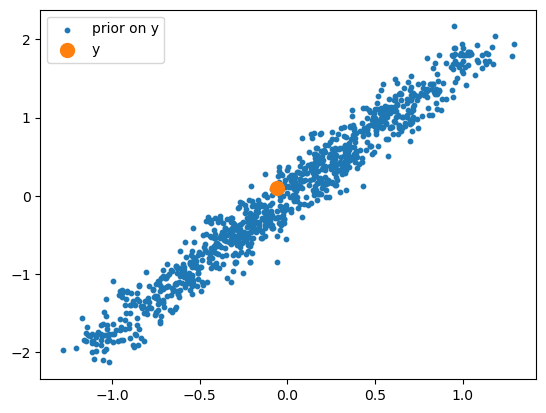

In [18]:
x_truth = sample(1).to(device)
y = x_truth @ A.t() + torch.randn(1, 2).to(device)*sigma_y

plt.scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label = 'prior on y', s=10)
plt.scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'y', s=100)
plt.legend()

In [19]:
## Only works with even stds?
def true_posterior_sampling(centers, stds, weights, y, A, sigma_y, n_samples):
    centers, stds, weights = centers.to(device), stds.to(device), weights.to(device)
    A, y = A.to(device), y.to(device)


    projected_centers = centers.to(device) @ A.to(device).T
    projected_covs = stds.reshape(-1, 1,1)**2 * (A @ A.T).reshape(1,2,2) + sigma_y**2 * torch.eye(2).reshape(1,2,2).to(device)

    projected_y_rescaled = y - projected_centers
    quadratic = torch.einsum('ki, kij, kj -> k', projected_y_rescaled, torch.inverse(projected_covs), projected_y_rescaled)

    weights_modifier = torch.exp(-1/2*quadratic)/torch.sqrt(torch.det(projected_covs))
    weights_modified = weights * weights_modifier
    weights_modified = weights_modified/weights_modified.sum()
    
    Sigma = torch.inverse((torch.eye(2).to(device)/stds.reshape(-1,1,1)**2) + A.T @ A / sigma_y**2)
    new_centers = (y @ A.T / sigma_y**2).reshape(1, 2) + centers/(stds**2).reshape(-1, 1)
    new_centers = torch.einsum('bi, bij -> bj', new_centers, Sigma)
    centers_idx = torch.multinomial(weights_modified, n_samples, replacement=True)
    samples = new_centers[centers_idx] + torch.einsum('bij, bj -> bi', torch.linalg.cholesky(Sigma[centers_idx]), torch.randn(n_samples, 2).to(device))
    return samples, new_centers, Sigma, weights_modified


In [20]:
posterior_samples, new_centers, Sigma, weights_modified = true_posterior_sampling(centers, stds, weights, y, A, sigma_y, 10000)

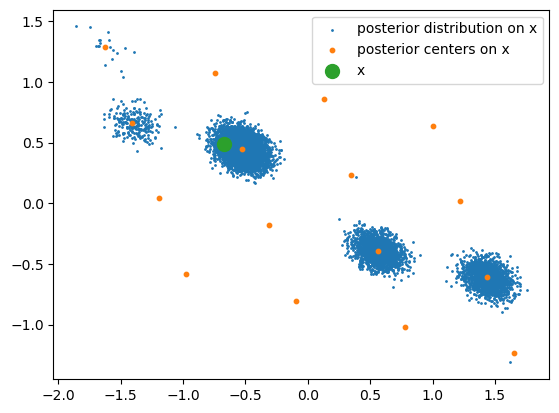

In [21]:
plt.scatter(posterior_samples.cpu()[:,0], posterior_samples.cpu()[:,1], label = 'posterior distribution on x', s=1)
plt.scatter(new_centers.cpu()[:,0], new_centers.cpu()[:,1], label = 'posterior centers on x', s=10)
plt.scatter(x_truth.cpu()[:,0], x_truth.cpu()[:,1], label = 'x', s=100)
plt.legend()

## DPS

In [22]:
def dps_sampling(diffusion_model, sample_size, observation, forward_log_likelihood, solver, verbose = False, time_rescaling=False, eta=1):
    diffusion_model.eval()
    def f(x_t, t):
        x_t.requires_grad_(True)
        model_output = diffusion_model.network(x_t, t)
        x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t, model_output)
        Beta_t = diffusion_model.sde.Beta(t).reshape(-1)
        rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1)
        #g = torch.sum((forward_model(x_hat_0) - observation)**2, dim=1)/2/(rescaling**2/10+sigma_y**2)
        #g = torch.sum((forward_model(x_hat_0) - observation)**2)/sigma_y**2/2
        g = - forward_log_likelihood(x_hat_0, observation, time_rescaling*rescaling**2/eta)
        rescaling = rescaling.reshape(-1, 1)
        guidance = torch.autograd.grad(g.sum(), x_t, create_graph=True)[0]*rescaling
        x_t = x_t.detach()
        return diffusion_model.sde.reverse(x_t, t, guidance+model_output)[0] 
        ##The strength of the guidance could be modulated...(see previous commits)

    def gdW(x_t, t):
        dummy_output = torch.zeros_like(x_t)
        return diffusion_model.sde.reverse(x_t, t, dummy_output)[1]
    
    x_init = diffusion_model.sde.prior_sampling((sample_size, diffusion_model.network.ndim)).to(device)
    gen = solver.forward(x_init, f, gdW, reverse_time = True, verbose = verbose)

    return gen

In [23]:
num_samples = 10000
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)

In [24]:
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_log_likelihood, EulerMaruyama(schedule), time_rescaling=True, eta=10, verbose=True)

100%|█████████▉| 999/1000 [00:02<00:00, 421.75it/s]


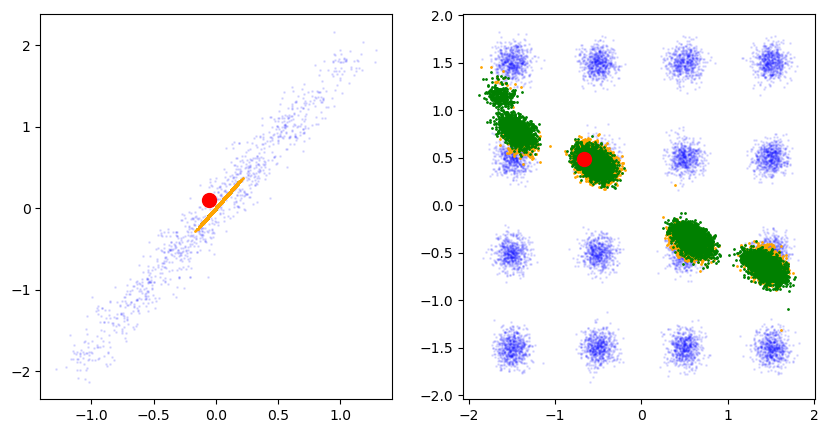

In [25]:
generated = generated.cpu().detach()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
generated_projection = generated @ A.t().to('cpu')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')


ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')


Text(0.5, 1.0, 'Posterior')

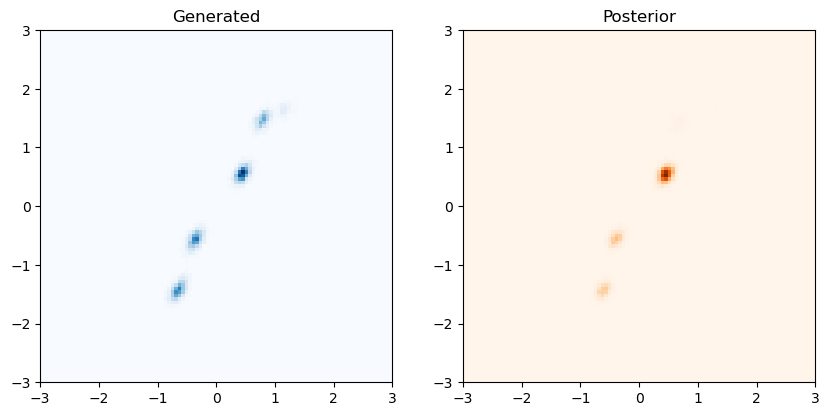

In [26]:
## Compare empirical posterior with true posterior density

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
bins_range = [[-3, 3], [-3, 3]]
hist_generated = np.histogram2d(generated.numpy()[:,0], generated.numpy()[:,1], bins = 100, range = bins_range)
hist_posterior = np.histogram2d(posterior_samples.cpu().detach().numpy()[:,0], posterior_samples.cpu().detach().numpy()[:,1], bins = 100, range = bins_range)
ax[0].imshow(hist_generated[0], extent = [bins_range[0][0], bins_range[0][1], bins_range[1][0], bins_range[1][1]], cmap = 'Blues')
ax[0].set_title('Generated')
ax[1].imshow(hist_posterior[0], extent = [bins_range[0][0], bins_range[0][1], bins_range[1][0], bins_range[1][1]], cmap = 'Oranges')
ax[1].set_title('Posterior')


## TDS

In [27]:
## A twisted diffusion sampler to solve the inverse problem.

def twisted_diffusion_sampler(diffusion_model, sample_size, observation, forward_log_likelihood, schedule, eta = 1, threshold_resampling = 0.9, return_auxiliary = False, verbose=True):
    times = schedule.flip(1)
    diffusion_model.eval()
    ndim = diffusion_model.network.ndim
    # Initialization
    x_t = diffusion_model.sde.prior_sampling((sample_size, ndim)).to(device)
    x_t.requires_grad_(True)
    t = times[:,0].to(device).unsqueeze(1)
    # Precompute some terms for loop initialization
    model_output = diffusion_model.network(x_t, t)
    x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t, model_output)
    Beta_t = diffusion_model.sde.Beta(t).reshape(-1)
    rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1)
    #g = -torch.sum((forward_model(x_hat_0) - observation)**2, dim=1)/(rescaling**2/eta+sigma_y**2)/2 - torch.log(rescaling**2/eta+sigma_y**2)/2*ndim
    g = forward_log_likelihood(x_hat_0, observation, rescaling**2/eta)
    guidance = torch.autograd.grad(-g.sum(), x_t, create_graph=True)[0]
    # First set of weights
    log_p_obs_given_x_t = g
    log_weights = log_p_obs_given_x_t

    # Loop parameters and variables
    nsteps = times.shape[1]-1
    progress_bar = tqdm.tqdm(total=nsteps, disable = not verbose)
    memory_every = 160
    memory_samples = []
    ratio=[]
    ess_list = []
    for i in range(nsteps):
        with torch.no_grad():  
            # Weights computation 
            weights = torch.softmax(log_weights, dim=0)
            ess = 1/(weights**2).sum().item()
            ess_list.append(ess)
            # Resampling
            if ess < sample_size*threshold_resampling:
                idx = torch.multinomial(weights, sample_size, replacement=True)
                x_t = x_t[idx]
                guidance = guidance[idx]
                model_output = model_output[idx]
                log_p_obs_given_x_t = log_p_obs_given_x_t[idx]
                log_weights = torch.zeros_like(log_weights)
            if i%memory_every == 0:
                memory_samples.append(x_t.cpu().detach().numpy())

            # Time step
            t_1 = times[:,i+1].to(device).unsqueeze(1)
            dt = t_1 - t

            # Compute the drift and diffusion terms
            ## Unconditional drift and diffusion (i.e. without guidance)
            unconditional_drift, unconditional_diffusion = diffusion_model.sde.reverse(x_t, t, model_output)
            ## Conditional drift (i.e. with guidance)
            Beta_t = diffusion_model.sde.Beta(t).reshape(-1, 1)
            rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1, 1)*(i!=nsteps-1)
            conditionnal_drift, _ = diffusion_model.sde.reverse(x_t, t, model_output + guidance*rescaling)

            # Diffuse the particles + compute different log-likelihood terms
            ## Diffusion
            beta_t = diffusion_model.sde.beta(t).reshape(-1, 1)
            std_diffusion = torch.sqrt(torch.abs(dt)*beta_t).reshape(-1)
            x_t_1 = x_t + conditionnal_drift*dt + unconditional_diffusion*torch.sqrt(torch.abs(dt))
            ## Log-likelihood terms
            log_p_x_t_1_given_x_t = -torch.sum((x_t_1 - (x_t + unconditional_drift*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
            log_p_x_t_1_given_x_t_guidance = -torch.sum((x_t_1 - (x_t + conditionnal_drift*dt))**2, dim = 1)/(2*std_diffusion**2)# - torch.log(std_diffusion)*ndim
        

        x_t = x_t_1.detach()
        x_t.requires_grad_(True)


        model_output = diffusion_model.network(x_t, t_1)
        x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t_1, model_output)
        
        Beta_t_1 = diffusion_model.sde.Beta(t_1).reshape(-1)
        rescaling = torch.sqrt(1 - torch.exp(-Beta_t_1)).reshape(-1)
        g = forward_log_likelihood(x_hat_0, observation, rescaling**2/eta)

        guidance = torch.autograd.grad(-g.sum(), x_t, create_graph=True)[0]

        log_p_obs_given_x_t_1 = g
        if i==nsteps-1:
            log_p_obs_given_x_t_1 = forward_log_likelihood(x_hat_0, observation, 0*rescaling**2/eta)
        log_weights += log_p_x_t_1_given_x_t - log_p_x_t_1_given_x_t_guidance +(log_p_obs_given_x_t_1- log_p_obs_given_x_t)

        log_p_obs_given_x_t = log_p_obs_given_x_t_1
        t = t_1
        ratio.append(rescaling[0].item()**2/eta/sigma_y**2)
        progress_bar.update(1)
    progress_bar.close()
    weights = torch.softmax(log_weights, dim=0)
    ess_list.append(1/(weights**2).sum().item())
    idx = torch.multinomial(weights, sample_size, replacement=True)
    if return_auxiliary:
        return x_t[idx], ess_list, memory_samples, ratio
    return x_t[idx]

In [28]:
num_samples = 300
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = power_law_schedule(t_min = tmin, t_max = tmax, n_iter = 1000, power = 2)

generated, ess, memory_samples, ratios = twisted_diffusion_sampler(exact_dm, num_samples, y.to(device), forward_log_likelihood, schedule, eta = 1, return_auxiliary = True)

  7%|▋         | 71/999 [00:00<00:02, 352.40it/s]

100%|██████████| 999/999 [00:02<00:00, 367.02it/s]


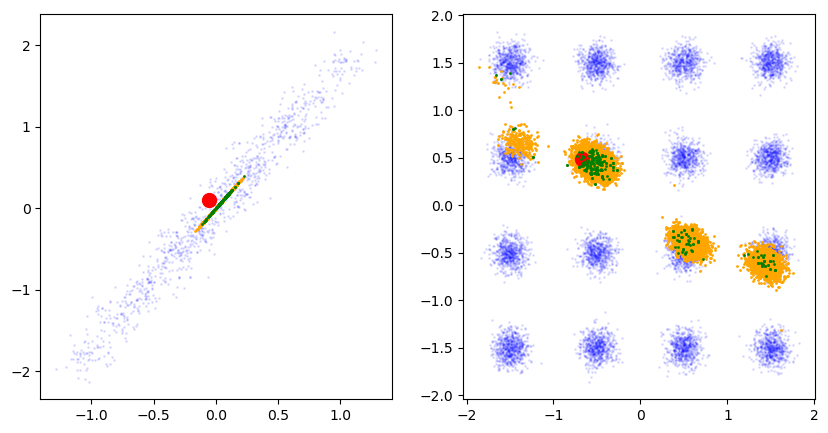

In [29]:
generated = generated.cpu().detach()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')
generated_projection = generated @ A.t().to('cpu')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

20.24776263351665


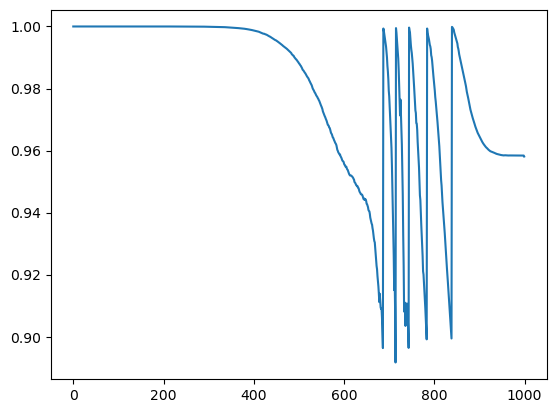

In [30]:
## ESS/number of particles
ess = np.array(ess)
plt.plot(ess/num_samples)
print(np.sum(1-ess[:-1]/num_samples))

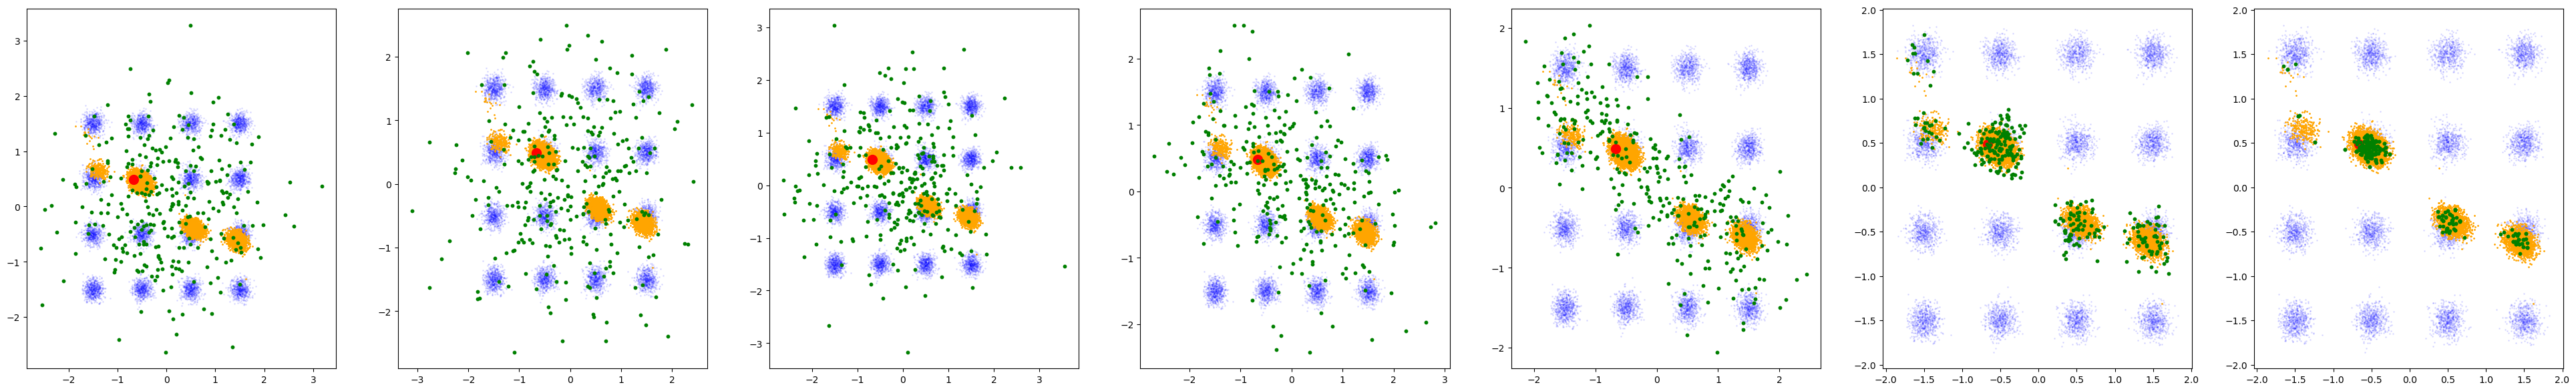

In [31]:
length = len(memory_samples)
length = 6
fig, ax = plt.subplots(1, length+1, figsize = (7*(length+1), 7))
for i in range(length):
    ax[i].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
    ax[i].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
    ax[i].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
    ax[i].scatter(memory_samples[i][:,0], memory_samples[i][:,1], label = 'generated', s=10, color='green')
    # Vector plot of model outputs and then guidance
    #ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_mo[i][:,0], -memory_mo[i][:,1], color='green')
    #ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_g[i][:,0], -memory_g[i][:,1], color='red')

id = length
ax[id].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[id].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[id].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[id].scatter(generated[:,0], generated[:,1], label = 'generated', s=10, color='green')

Text(0.5, 1.0, 'Posterior')

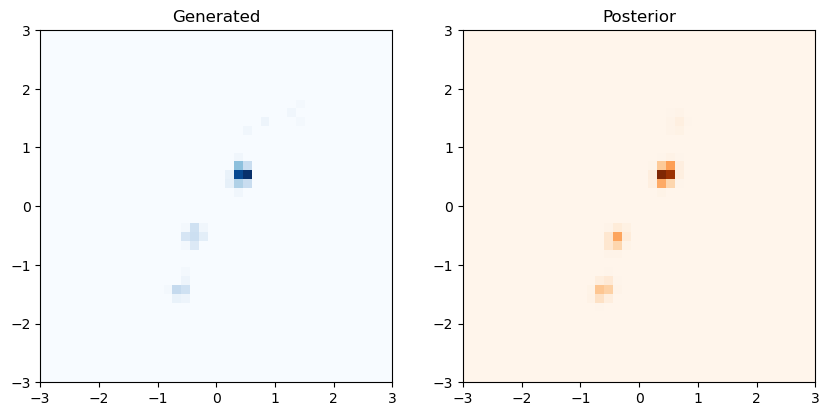

In [32]:
## Compare empirical posterior with true posterior density

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
bins_range = [[-3, 3], [-3, 3]]
bins = 40
hist_generated = np.histogram2d(generated.numpy()[:,0], generated.numpy()[:,1], bins = bins, range = bins_range)
hist_posterior = np.histogram2d(posterior_samples.cpu().detach().numpy()[:,0], posterior_samples.cpu().detach().numpy()[:,1], bins = bins, range = bins_range)
ax[0].imshow(hist_generated[0], extent = [bins_range[0][0], bins_range[0][1], bins_range[1][0], bins_range[1][1]], cmap = 'Blues')
ax[0].set_title('Generated')
ax[1].imshow(hist_posterior[0], extent = [bins_range[0][0], bins_range[0][1], bins_range[1][0], bins_range[1][1]], cmap = 'Oranges')
ax[1].set_title('Posterior')


# Non Linear inverse problem

In [33]:
def soft_norm_regularization(x, alpha = 0.02):
    return x/(torch.norm(x, dim=1, keepdim=True) + alpha)

sigma_y = 0.1
forward_model = lambda x: soft_norm_regularization(x)
y = forward_model(x_truth) + torch.randn(1, 2).to(device)*sigma_y

def forward_log_likelihood(x, y, rescaling_factor = 0):
    ndim = x.shape[1]
    return -torch.sum((forward_model(x) - y)**2, dim=1)/(rescaling_factor+sigma_y**2)/2 - torch.log(rescaling_factor+sigma_y**2)/2*ndim

In [34]:
## Evaluate true posterior using importance sampling with the prior as proposal

num_samples = 30000

prior_samples = sample(num_samples).to(device)

log_likelihood = -1/2*torch.sum((forward_model(prior_samples) - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2)

importance_weights = torch.softmax(log_likelihood, dim=0)

samples_idx = torch.multinomial(importance_weights, 5000, replacement=True)

posterior_samples = prior_samples[samples_idx]

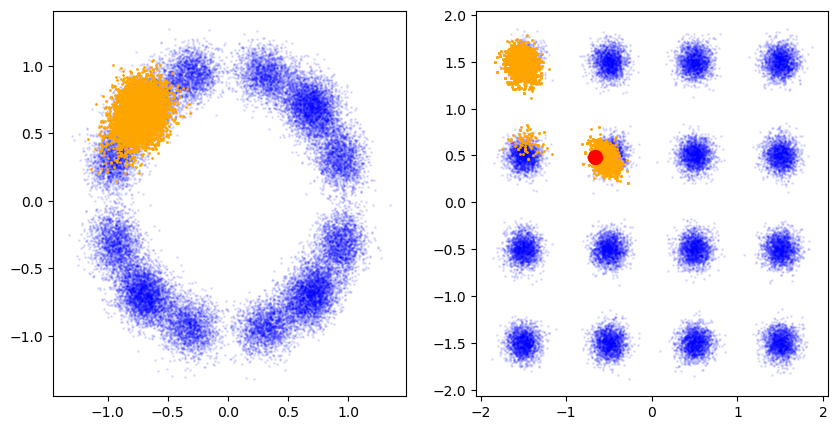

In [35]:
## Plot the projected prior and the true posterior as well as the observation y

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
projected_prior = forward_model(prior_samples).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
projected_posterior = forward_model(posterior_samples).cpu() + sigma_y*torch.randn_like(posterior_samples).cpu()
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

## DPS

In [36]:
## DPS
num_samples = 1000
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_log_likelihood, EulerMaruyama(schedule), time_rescaling=True, eta=10, verbose=True)

100%|█████████▉| 999/1000 [00:02<00:00, 410.64it/s]


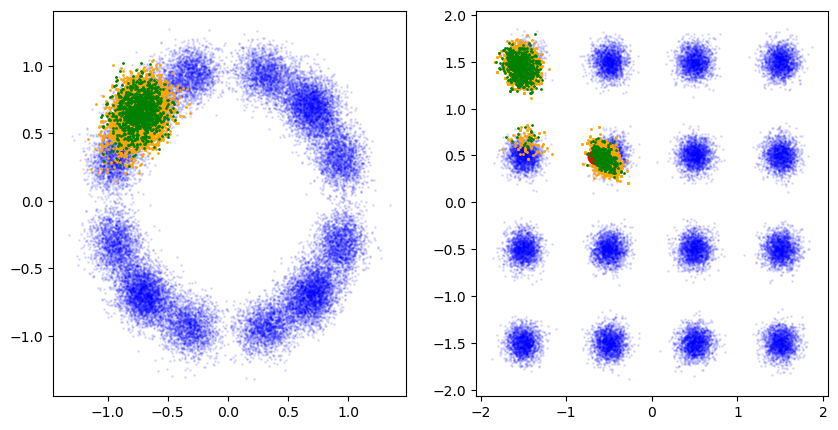

In [37]:
## Plot DPS samples and their projections with all other relevant distributions

generated = generated.cpu().detach()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')
generated_projection = forward_model(generated).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

## TDS

In [38]:
num_samples = 300
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)

In [39]:
generated, ess, memory_samples,ratios = twisted_diffusion_sampler(exact_dm, num_samples, y.to(device), forward_log_likelihood, schedule, eta = 1, return_auxiliary=True)

100%|██████████| 999/999 [00:02<00:00, 364.15it/s]


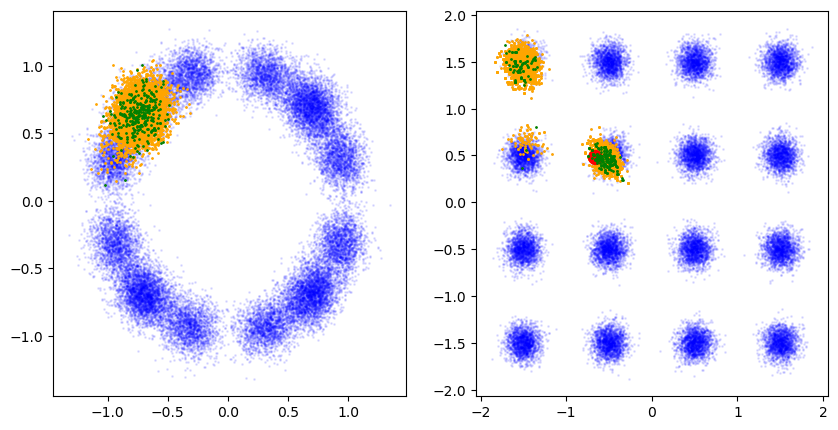

In [40]:
## Plot DPS samples and their projections with all other relevant distributions

generated = generated.cpu().detach()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')
generated_projection = forward_model(generated).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

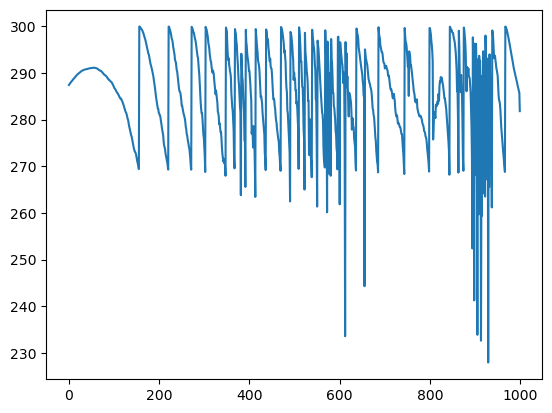

In [41]:
plt.plot(ess)

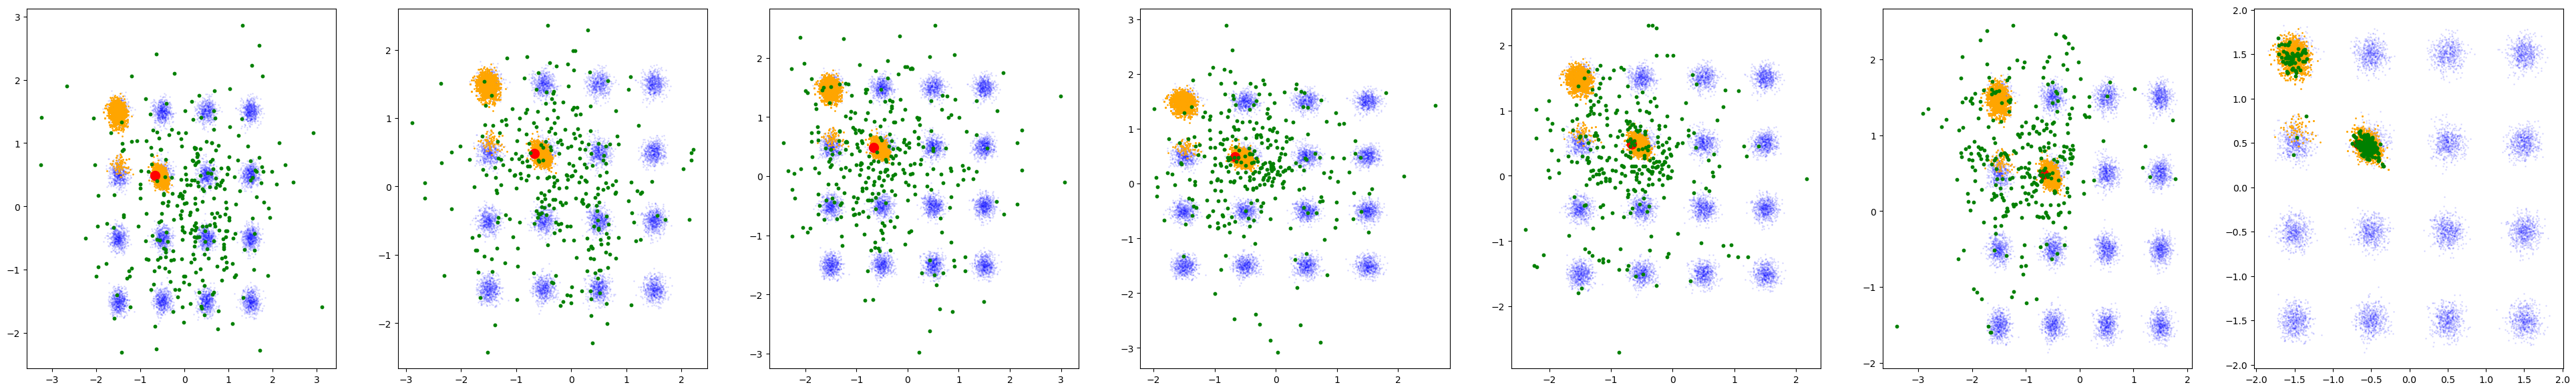

In [42]:

fig, ax = plt.subplots(1, length+1, figsize = (7*(length+1), 7))
for i in range(length):
    ax[i].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
    ax[i].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
    ax[i].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
    ax[i].scatter(memory_samples[i][:,0], memory_samples[i][:,1], label = 'generated', s=10, color='green')
    # Vector plot of model outputs and then guidance
    #ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_mo[i][:,0], -memory_mo[i][:,1], color='green')
    #ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_g[i][:,0], -memory_g[i][:,1], color='red')

id = length
ax[id].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[id].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[id].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[id].scatter(generated[:,0], generated[:,1], label = 'generated', s=10, color='green')

# Blind Inverse Problem

## Setting

In [43]:
def blind_non_linear_operator(x,phi):
    y = soft_norm_regularization(x) # (b, ndim)
    diag_phi = torch.diag_embed(phi) # (b, ndim, ndim)
    return torch.einsum('bj, bij -> bi', y, diag_phi) # (b, ndim)

In [44]:
def log_prior_phi(phi):
    ## Gaussian prior centered at 3 with std 1
    return -torch.sum((phi-3)**2, dim=1)/2 - np.log(2*np.pi)/2*2

def sample_prior_phi(n_samples):
    return torch.randn(n_samples, 2) + 3

In [45]:
phi_true = torch.tensor([1., 2.]).to(device).reshape(1, -1)
phi_true = sample_prior_phi(1).to(device)
sigma_y = 0.03

forward_model_true = lambda x: blind_non_linear_operator(x, phi_true)

forward_model_blind = lambda x, phi: blind_non_linear_operator(x, phi)

x_truth = sample(1).to(device)

y = forward_model_true(x_truth) + torch.randn(1, 2).to(device)*sigma_y

projected_prior = forward_model_true(prior_samples).cpu() + torch.randn(prior_samples.shape[0], 2).cpu()*sigma_y

In [46]:
def forward_log_likelihood_x_phi(x, phi, y, rescaling_factor=torch.zeros(1)):
    rescaling_factor = rescaling_factor.to(x.device)
    return -torch.sum((forward_model_blind(x, phi) - y)**2, dim=-1)/(rescaling_factor+sigma_y**2)/2 - torch.log(rescaling_factor+sigma_y**2)/2*ndim

def forward_log_likelihood_true(x, y, rescaling_factor=torch.zeros(1)):
    rescaling_factor = rescaling_factor.to(x.device)
    return -torch.sum((forward_model_true(x) - y)**2, dim=-1)/(rescaling_factor+sigma_y**2)/2 - torch.log(rescaling_factor+sigma_y**2)/2*ndim

In [47]:
def forward_log_likelihood_marginalized_MC(x, y, rescaling_factor = 0, n_MC_samples = 100):
    ndim = x.shape[1]
    phi = sample_prior_phi(n_MC_samples*x.shape[0]).to(x.device)
    log_prior = log_prior_phi(phi)
    ## Repeat x n_MC_samples times along batch dimension
    x = x.unsqueeze(1).repeat(1, n_MC_samples, 1).reshape(-1, ndim)
    rfactor = rescaling_factor.unsqueeze(1).repeat(1, n_MC_samples, 1).reshape(-1)
    #log_likelihood_x_phi = -torch.sum((forward_model_blind(x, phi) - y)**2, dim=-1)/(rfactor+sigma_y**2)/2 - torch.log(rfactor+sigma_y**2)/2*ndim
    log_likelihood_x_phi = forward_log_likelihood_x_phi(x, phi, y, rfactor)
    log_likelihood_x_post_on_phi = log_likelihood_x_phi+ log_prior
    log_likelihood_x_post_on_phi = log_likelihood_x_post_on_phi.reshape(-1, n_MC_samples)
    log_likelihood_marginalized = torch.logsumexp(log_likelihood_x_post_on_phi, dim=1)
    return log_likelihood_marginalized

## Projected prior and true posterior

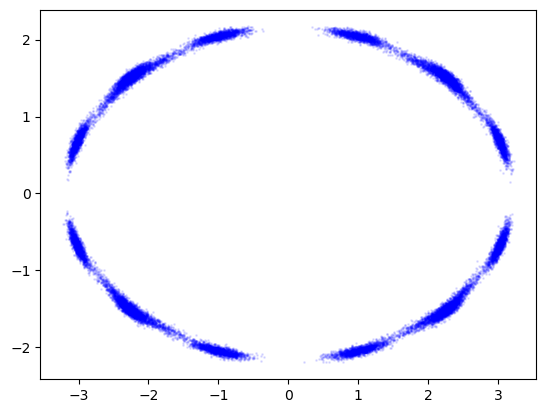

In [48]:
## Plot the projected prior 
plt.scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)

In [49]:
## Estimate the true posterior on (x,phi) using importance sampling with the prior as proposal for both x and phi

num_samples = 1000000

prior_samples = sample(num_samples).to(device)
prior_phi = sample_prior_phi(num_samples).to(device)

log_likelihood = forward_log_likelihood_x_phi(prior_samples, prior_phi, y.to(device))

log_posterior_weights = log_likelihood 

importance_weights = torch.softmax(log_posterior_weights, dim=0)

samples_idx = torch.multinomial(importance_weights, 10000, replacement=True)

posterior_samples = prior_samples[samples_idx]
posterior_phi = prior_phi[samples_idx]

#Randomly select 10000 samples from the prior for plotting purposes
prior_samples = prior_samples[:10000]

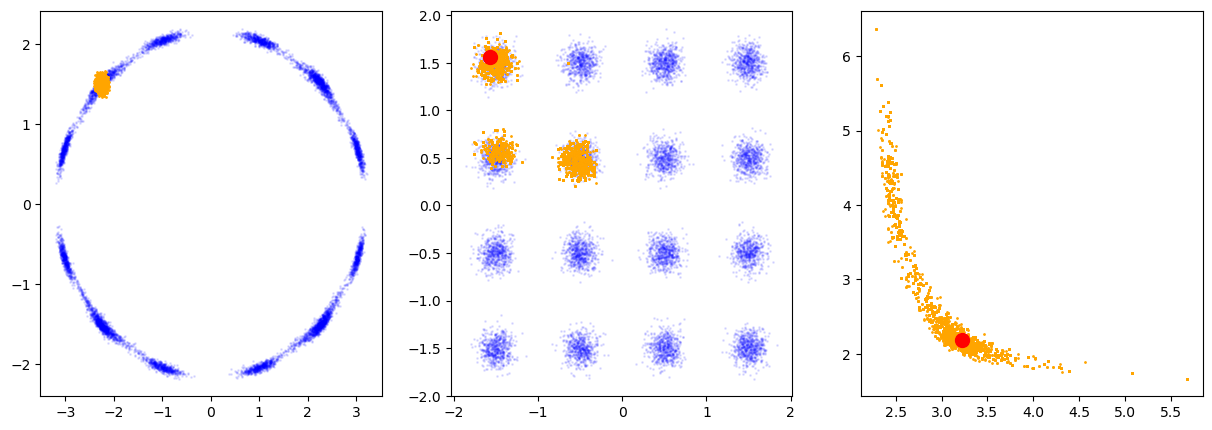

In [50]:
## Plot the projected prior on x, the projected true posterior on x and the projected observation y
## Also plot the prior on x, the true posterior on x and x_truth
## Also plot the posterior on phi (flat prior)

importance_samples = posterior_samples.cpu().detach()
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
projected_prior = forward_model_true(prior_samples).cpu() + torch.randn(prior_samples.shape[0], ndim).cpu()*sigma_y
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
projected_posterior = forward_model_blind(posterior_samples,posterior_phi).cpu() + torch.randn(10000, ndim).cpu()*sigma_y
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

#ax[2].scatter(prior_phi.cpu()[:,0], prior_phi.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[2].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[2].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')


In [51]:
def effective_sample_size(weights):
    return 1/torch.sum(weights**2)

In [52]:
## ESS of naive importance sampling method

effective_sample_size(importance_weights)/num_samples

tensor(0.0004, device='cuda:0')

## TDS on marginalized likelihood

In [53]:
num_samples = 1000
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
n_MC_blind = 1000
forward_log_likelihood_marginalized = lambda x, y, rescaling_factor: forward_log_likelihood_marginalized_MC(x, y, rescaling_factor, n_MC_blind)

In [54]:
## Sample x|y (marginalized over phi) using TDS with custom MC_estimated log-likelihood
generated, ess, memory_samples,ratios = twisted_diffusion_sampler(exact_dm, num_samples, y.to(device), forward_log_likelihood_marginalized, schedule, eta = 0.3, return_auxiliary=True, verbose=True)
## Sample phi|x,y using HMC

#HMC helpers
phi_min = torch.tensor([0.5, 0.5]).to(device)
phi_max = torch.tensor([2.5, 2.5]).to(device)

coll_manager = lambda q, p, pnext: collision_manager(q, p, pnext, phi_min, phi_max)

## Define log_posterior for phi

def log_posterior_phi(phi):
    ll = forward_log_likelihood_x_phi(generated, phi, y, torch.zeros(phi.shape[0]).to(phi.device))
    return ll + log_prior_phi(phi)

def log_prob_grad(phi):
    phi.requires_grad_(True)
    log_post_phi = log_posterior_phi(phi)
    grad = torch.autograd.grad(log_post_phi, phi, grad_outputs=torch.ones_like(log_post_phi))[0]
    return log_post_phi.detach(), grad.detach()

phi_init = sample_prior_phi(generated.shape[0]).to(device)
hmc = HMC(log_posterior_phi, log_prob_and_grad=log_prob_grad)
hmc.set_collision_fn(coll_manager)
samples = hmc.sample(phi_init, nsamples=10, burnin=1, step_size=1e-4, nleap=(5,15), epsadapt=100, verbose=False, ret_side_quantities=False)


  2%|▏         | 21/999 [00:00<00:15, 63.84it/s]

100%|██████████| 999/999 [00:15<00:00, 66.16it/s]


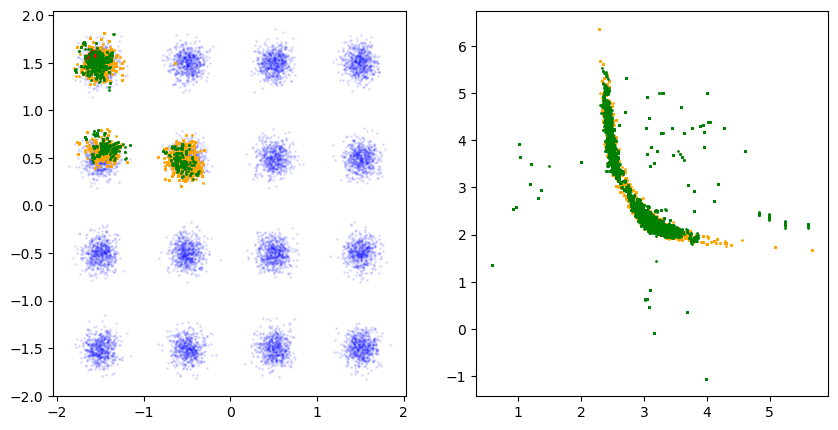

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[0].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[0].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
generated = generated.cpu().detach()
ax[0].scatter(generated[:,0],generated[:,1], label = 'Estimated Posterior', color='green', s=1)

ax[1].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')
estimated_phi_posterior = samples.cpu().detach().reshape(-1,2)
ax[1].scatter(estimated_phi_posterior[:,0], estimated_phi_posterior[:,1], label = 'estimated posterior', s=1, color='green')

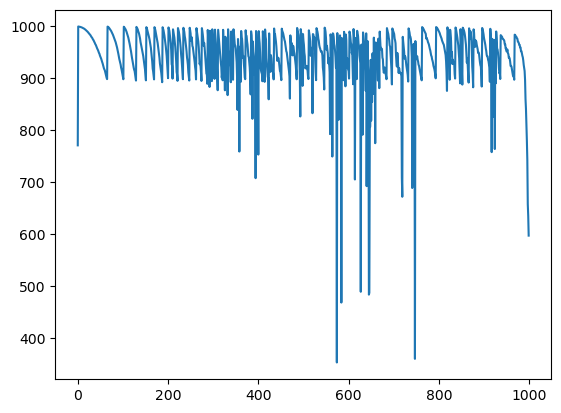

In [56]:
plt.plot(ess)

## DPS on marginalized likelihood

In [57]:
## Sample x|y (marginalized over phi) using TDS with custom MC_estimated log-likelihood
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_log_likelihood_marginalized, EulerMaruyama(schedule), eta = 1, time_rescaling=True, verbose=True)
## Sample phi|x,y using HMC

#HMC helpers
phi_min = torch.tensor([0.5, 0.5]).to(device)
phi_max = torch.tensor([2.5, 2.5]).to(device)

coll_manager = lambda q, p, pnext: collision_manager(q, p, pnext, phi_min, phi_max)

## Define log_posterior for phi

def log_posterior_phi(phi):
    ll = forward_log_likelihood_x_phi(generated, phi, y, torch.zeros(phi.shape[0]).to(phi.device))
    return ll + log_prior_phi(phi)

def log_prob_grad(phi):
    phi.requires_grad_(True)
    log_post_phi = log_posterior_phi(phi)
    grad = torch.autograd.grad(log_post_phi, phi, grad_outputs=torch.ones_like(log_post_phi))[0]
    return log_post_phi.detach(), grad.detach()

phi_init = sample_prior_phi(generated.shape[0]).to(device)
hmc = HMC(log_posterior_phi, log_prob_and_grad=log_prob_grad)
hmc.set_collision_fn(coll_manager)
samples = hmc.sample(phi_init, nsamples=10, burnin=1, step_size=1e-4, nleap=(5,15), epsadapt=100, verbose=False, ret_side_quantities=False)


100%|█████████▉| 999/1000 [00:14<00:00, 69.87it/s]


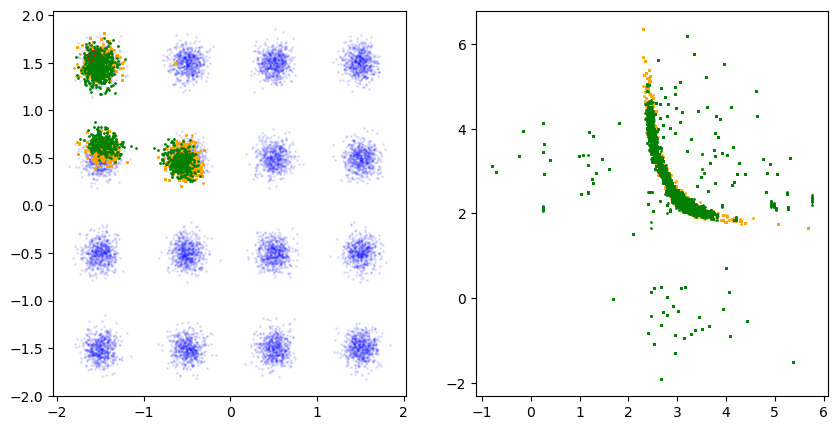

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[0].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[0].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
generated = generated.cpu().detach()
ax[0].scatter(generated[:,0],generated[:,1], label = 'Estimated Posterior', color='green', s=1)

ax[1].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')
estimated_phi_posterior = samples.cpu().detach().reshape(-1,2)
ax[1].scatter(estimated_phi_posterior[:,0], estimated_phi_posterior[:,1], label = 'estimated posterior', s=1, color='green')

Text(0.5, 1.0, 'Posterior phi')

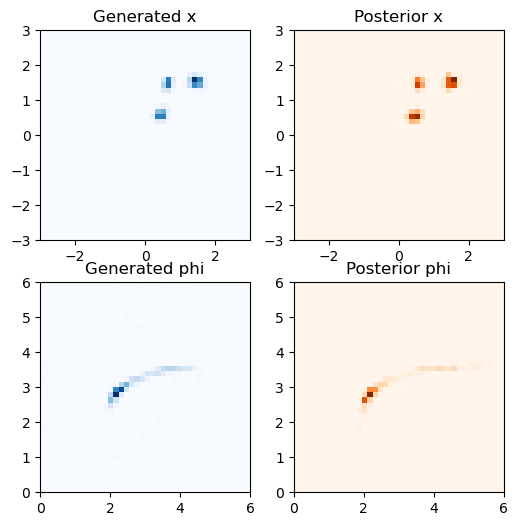

In [59]:
## Empirical density comparison

fig, ax = plt.subplots(2, 2, figsize = (6, 6))
bins_range_x = [[-3, 3], [-3, 3]]
bins_range_phi = [[0, 6], [0, 6]]
bins = 40
hist_generated_x = np.histogram2d(generated.numpy()[:,0], generated.numpy()[:,1], bins = bins, range = bins_range_x)
hist_posterior_x = np.histogram2d(posterior_samples.cpu().detach().numpy()[:,0], posterior_samples.cpu().detach().numpy()[:,1], bins = bins, range = bins_range_x)
hist_generated_phi = np.histogram2d(estimated_phi_posterior.numpy()[:,0], estimated_phi_posterior.numpy()[:,1], bins = bins, range = bins_range_phi)
hist_posterior_phi = np.histogram2d(posterior_phi.cpu().detach().numpy()[:,0], posterior_phi.cpu().detach().numpy()[:,1], bins = bins, range = bins_range_phi)

ax[0,0].imshow(hist_generated_x[0], extent = [bins_range_x[0][0], bins_range_x[0][1], bins_range_x[1][0], bins_range_x[1][1]], cmap = 'Blues')
ax[0,0].set_title('Generated x')
ax[0,1].imshow(hist_posterior_x[0], extent = [bins_range_x[0][0], bins_range_x[0][1], bins_range_x[1][0], bins_range_x[1][1]], cmap = 'Oranges')
ax[0,1].set_title('Posterior x')
ax[1,0].imshow(hist_generated_phi[0], extent = [bins_range_phi[0][0], bins_range_phi[0][1], bins_range_phi[1][0], bins_range_phi[1][1]], cmap = 'Blues')
ax[1,0].set_title('Generated phi')
ax[1,1].imshow(hist_posterior_phi[0], extent = [bins_range_phi[0][0], bins_range_phi[0][1], bins_range_phi[1][0], bins_range_phi[1][1]], cmap = 'Oranges')
ax[1,1].set_title('Posterior phi')

## Non collapsed TDS sampling

In [60]:
## Generative prior on phi (via a diffusion model)
centers_phi = torch.tensor([3., 3.]).to(device).reshape(1, -1)
std_phi = torch.tensor([1., 1.]).to(device).reshape(1, -1)
weights_phi = torch.tensor([1.]).to(device)
score_net_phi = ExactScoreNetwork(centers=centers_phi, stds=std_phi, weights=weights_phi)
exact_dm_phi = ContinuousSBM(sde, score_net_phi)

In [61]:
## Check the prior on phi
num_samples = 1000

prior_samples_phi = sample_prior_phi(num_samples).to(device)

t = torch.ones(n_samples).to(device)*1
tmin = torch.ones(n_samples).to(device)*sde.tmin
schedule = power_law_schedule(t_min = tmin, t_max = t, n_iter = 1000, power = 2)
generative_prior_samples = exact_dm_phi.generate_image(num_samples, schedule=schedule)

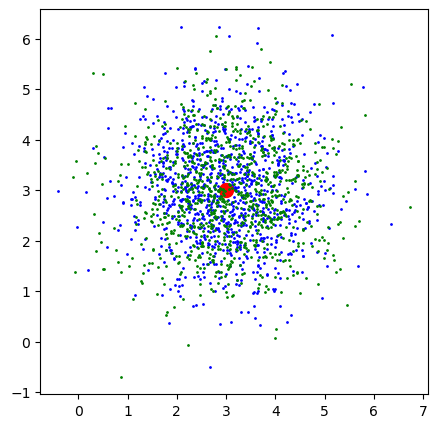

In [62]:
## Plot the generative prior on phi vs the true prior on phi

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(prior_samples_phi.cpu()[:,0], prior_samples_phi.cpu()[:,1], label = 'prior', s=1, color='blue')
ax.scatter(centers_phi[:,0].to('cpu'), centers_phi[:,1].to('cpu'), label = 'truth', s=100, color='red')
generative_prior_samples = generative_prior_samples.cpu().detach()
ax.scatter(generative_prior_samples[:,0], generative_prior_samples[:,1], label = 'Generative Prior', s=1, color='green')


In [63]:
## A twisted diffusion sampler to solve the blind inverse problem

def twisted_diffusion_sampler_blind(diffusion_model_x, diffusion_model_phi, sample_size, observation, 
                              forward_log_likelihood,
                              schedule, 
                              eta = 1,
                              threshold_resampling = 0.9, return_auxiliary = False, verbose=True):
    """
    Twisted diffusion sampler for solving the blind inverse problem.
    diffuion_model: a diffusion model with a 'network' and an SDE
    sample_size: number of particles
    observation: the observation y
    forward_log_likelihood: a function that takes x, phi, y, rescaling_factor (opt) and returns the log-likelihood of y given x and phi
    log_prior_phi: a function that takes phi and returns the log-prior of phi
    sample_prior_phi: a function that samples from the prior of phi
    schedule: a schedule object
    eta: the exploration rescaling factor in the diffusion
    phi_temperature_rescaling: if True, the temperature rescaling is applied to the guidance term for phi
    threshold_resampling: the threshold for the effective sample size under which resampling is triggered
    return_auxiliary: if True, the function returns the effective sample size, the memory of the samples and the rescaling factors
    verbose: if True, a progress bar is displayed
    """
    times = schedule.flip(1)
    diffusion_model_x.network.eval()
    diffusion_model_phi.network.eval()
    for param in diffusion_model_x.network.parameters():
        param.requires_grad = False
    for param in diffusion_model_phi.network.parameters():
        param.requires_grad = False
    ndim_x = diffusion_model_x.network.ndim
    ndim_phi = diffusion_model_phi.network.ndim
    # Initialization
    x_t = diffusion_model_x.sde.prior_sampling((sample_size, ndim)).to(device)
    phi_t = diffusion_model_phi.sde.prior_sampling((sample_size, ndim)).to(device)
    x_t.requires_grad_(True)
    phi_t.requires_grad_(True)
    t = times[:,0].to(device).unsqueeze(1)
    # Precompute some terms for loop initialization
    model_output_x = diffusion_model_x.network(x_t, t)
    model_output_phi = diffusion_model_phi.network(phi_t, t)
    x_hat_0 = diffusion_model_x.sde.tweedie_reverse(x_t, t, model_output_x)
    phi_hat_0 = diffusion_model_phi.sde.tweedie_reverse(phi_t, t, model_output_phi)
    Beta_t = diffusion_model_x.sde.Beta(t).reshape(-1)
    rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1)
    
    g = forward_log_likelihood(x_hat_0, phi_hat_0, observation, rescaling**2/eta)
    guidance = torch.autograd.grad(-g.sum(), [x_t, phi_t], create_graph=True)
    guidance_x = guidance[0]
    guidance_phi = guidance[1]
    # First set of weights
    log_p_obs_given_x_t_phi_t = g
    log_weights = log_p_obs_given_x_t_phi_t

    # Loop parameters and variables
    nsteps = times.shape[1]-1
    progress_bar = tqdm.tqdm(total=nsteps, disable = not verbose)
    memory_every = nsteps//7
    memory_samples = []
    ratio=[]
    ess_list = []

    for i in range(nsteps):
        with torch.no_grad():  
            # Weights computation 
            weights = torch.softmax(log_weights, dim=0)
            ess = 1/(weights**2).sum().item()
            ess_list.append(ess)
            # Resampling
            if ess < sample_size*threshold_resampling:
                idx = torch.multinomial(weights, sample_size, replacement=True)
                x_t = x_t[idx]
                phi_t = phi_t[idx]
                guidance_x = guidance_x[idx]
                guidance_phi = guidance_phi[idx]
                model_output_x = model_output_x[idx]
                model_output_phi = model_output_phi[idx]
                log_p_obs_given_x_t_phi_t = log_p_obs_given_x_t_phi_t[idx]
                log_weights = torch.zeros_like(log_weights)
            if i%memory_every == 0:
                memory_samples.append((x_t.cpu().detach().numpy(), phi_t.cpu().detach().numpy()))

            # Time step
            t_1 = times[:,i+1].to(device).unsqueeze(1)
            dt = t_1 - t

            # Compute the drift and diffusion terms
            ## Unconditional drift and diffusion (i.e. without guidance)
            unconditional_drift_x, unconditional_diffusion_x = diffusion_model_x.sde.reverse(x_t, t, model_output_x)
            unconditional_drift_phi, unconditional_diffusion_phi = diffusion_model_phi.sde.reverse(phi_t, t, model_output_phi)
            ## Conditional drift (i.e. with guidance)
            Beta_t = diffusion_model_x.sde.Beta(t).reshape(-1, 1)
            rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1, 1)*(i!=nsteps-1)
            conditionnal_drift_x, _ = diffusion_model_x.sde.reverse(x_t, t, model_output_x + guidance_x*rescaling)
            conditionnal_drift_phi, _ = diffusion_model_phi.sde.reverse(phi_t, t, model_output_phi + guidance_phi*rescaling)

            # Diffuse the particles + compute different log-likelihood terms
            ## Diffusion
            beta_t = diffusion_model_x.sde.beta(t).reshape(-1, 1)
            std_diffusion = torch.sqrt(torch.abs(dt)*beta_t).reshape(-1)
            x_t_1 = x_t + conditionnal_drift_x*dt + unconditional_diffusion_x*torch.sqrt(torch.abs(dt))
            phi_t_1 = phi_t + conditionnal_drift_phi*dt + unconditional_diffusion_phi*torch.sqrt(torch.abs(dt))
        ## Log-likelihood terms
        log_p_x_t_1_given_x_t = -torch.sum((x_t_1 - (x_t + unconditional_drift_x*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
        log_p_x_t_1_given_x_t_guidance = -torch.sum((x_t_1 - (x_t + conditionnal_drift_x*dt))**2, dim = 1)/(2*std_diffusion**2)# - torch.log(std_diffusion)*ndim
        log_p_phi_t_1_given_phi_t = -torch.sum((phi_t_1 - (phi_t + unconditional_drift_phi*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
        log_p_phi_t_1_given_phi_t_guidance = -torch.sum((phi_t_1 - (phi_t + conditionnal_drift_phi*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
        
        ## Updates
        x_t = x_t_1.detach()
        phi_t = phi_t_1.detach()
        x_t.requires_grad_(True)
        phi_t.requires_grad_(True)

        ## Next step computations
        model_output_x = diffusion_model_x.network(x_t, t_1)
        x_hat_0 = diffusion_model_x.sde.tweedie_reverse(x_t, t_1, model_output_x)
        model_output_phi = diffusion_model_phi.network(phi_t, t_1)
        phi_hat_0 = diffusion_model_phi.sde.tweedie_reverse(phi_t, t_1, model_output_phi)
        
        Beta_t_1 = diffusion_model_x.sde.Beta(t_1).reshape(-1)
        rescaling = torch.sqrt(1 - torch.exp(-Beta_t_1)).reshape(-1)

        g = forward_log_likelihood(x_hat_0, phi_hat_0, observation, rescaling**2/eta)

        guidance = torch.autograd.grad(-g.sum(), [x_t, phi_t], create_graph=True)
        guidance_x = guidance[0]
        guidance_phi = guidance[1]

        log_p_obs_given_x_t_1_phi_t_1 = g

        if i==nsteps-1:
            #log_p_obs_given_x_t_1_phi_t_1 = forward_log_likelihood(x_t, phi_t, observation, torch.zeros_like(rescaling))
            log_p_obs_given_x_t_1_phi_t_1 = forward_log_likelihood(x_hat_0, phi_hat_0, observation, torch.zeros_like(rescaling))
        
        log_weights+=log_p_phi_t_1_given_phi_t-log_p_phi_t_1_given_phi_t_guidance
        log_weights+=log_p_x_t_1_given_x_t-log_p_x_t_1_given_x_t_guidance
        log_weights+=log_p_obs_given_x_t_1_phi_t_1-log_p_obs_given_x_t_phi_t

        log_p_obs_given_x_t_phi_t = log_p_obs_given_x_t_1_phi_t_1
        t = t_1
        ratio.append(rescaling[0].item()**2/eta/sigma_y**2)
        progress_bar.update(1)
    progress_bar.close()
    weights = torch.softmax(log_weights, dim=0)
    ess_list.append(1/(weights**2).sum().item())
    idx = torch.multinomial(weights, sample_size, replacement=True)
    if return_auxiliary:
        return x_t[idx], phi_t[idx], ess_list, memory_samples, ratio
    return x_t[idx], phi_t[idx]

In [64]:
num_samples = 1000
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 200)

In [75]:
generated_x,generated_phi, ess, memory_samples, ratio = twisted_diffusion_sampler_blind(exact_dm, exact_dm_phi, num_samples, y.to(device), forward_log_likelihood_x_phi, schedule, eta = 0.1, return_auxiliary=True, verbose=True)

100%|██████████| 199/199 [00:00<00:00, 204.75it/s]


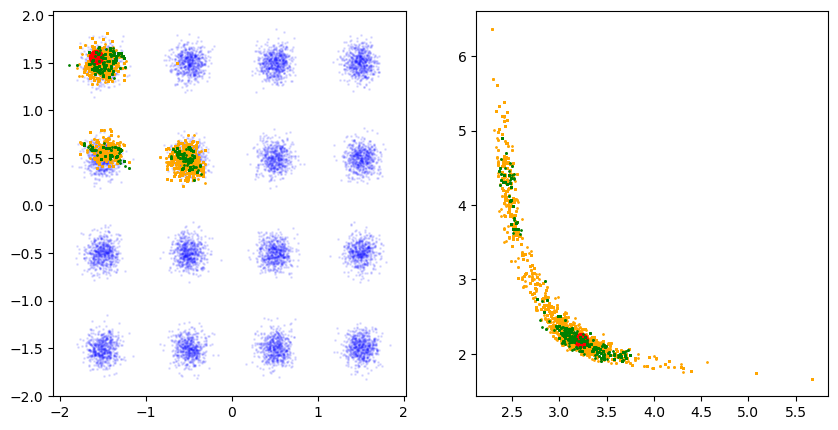

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[0].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[0].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
generated = generated_x.cpu().detach()
ax[0].scatter(generated[:,0],generated[:,1], label = 'Estimated Posterior', color='green', s=1)

ax[1].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')
estimated_phi_posterior = generated_phi.cpu().detach().reshape(-1,2)
ax[1].scatter(estimated_phi_posterior[:,0], estimated_phi_posterior[:,1], label = 'estimated posterior', s=1, color='green')

In [77]:
min(ess)

103.57626850182865

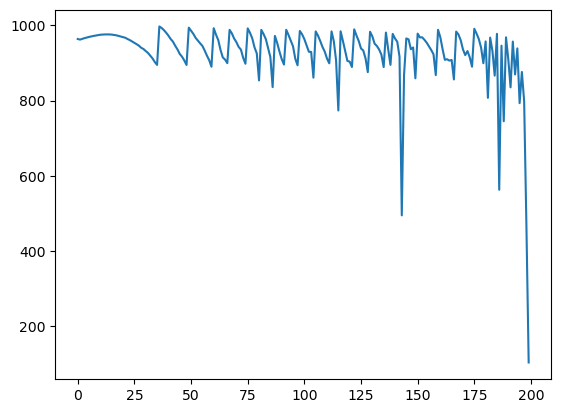

In [78]:
plt.plot(ess)

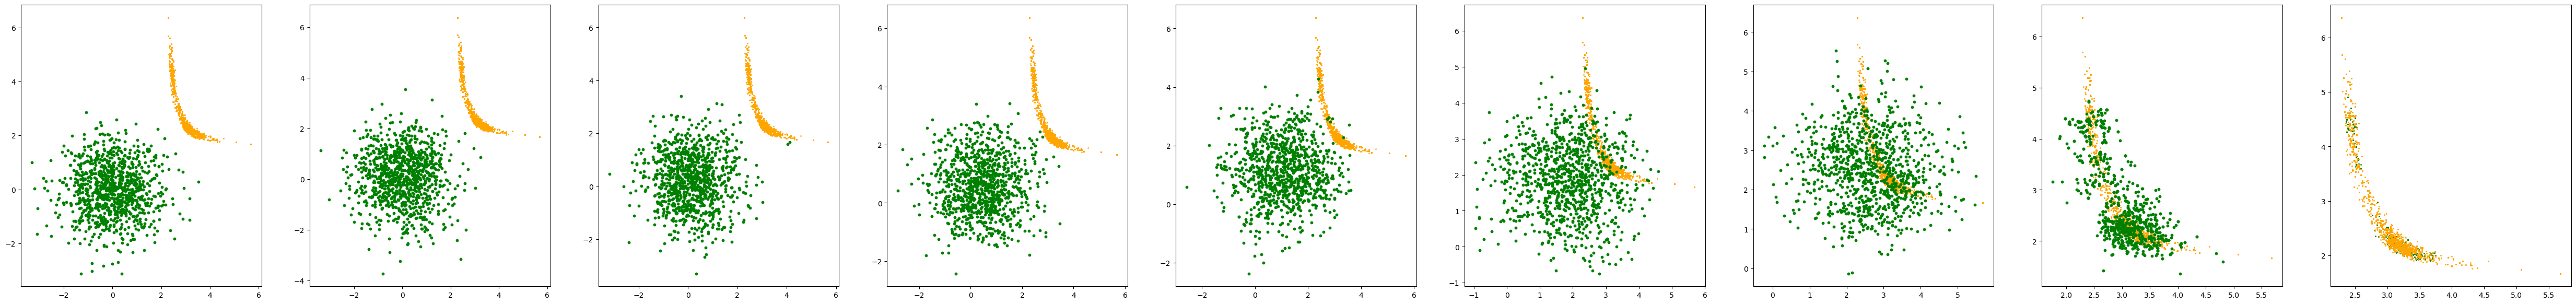

In [79]:
length = len(memory_samples)
length = 8
fig, ax = plt.subplots(1, length+1, figsize = (7*(length+1), 7))
for i in range(length):
    ax[i].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
    ax[i].scatter(memory_samples[i][1][:,0], memory_samples[i][1][:,1], label = 'generated', s=10, color='green')

id = length
ax[id].scatter(generated_phi.cpu().detach()[:,0], generated_phi.cpu().detach()[:,1], label = 'generated', s=1, color='green')
ax[id].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')